<h1>Using Voting Classifiers to recognise handwritten digits in the MNIST dataset</h1>

In this notebook we will train an ensemble classifier to recognise handwritten digits and examine the various ways of increasing the accuracy of said classifier through optimisation techniques.

In [24]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Voting classifiers 

Firstly loading the digits dataset and splitting it into training and test data

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import datasets
digits = datasets.load_digits()

X, y = digits["data"], digits["target"]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360
(1437, 64) (1437,) (360, 64) (360,)


Now training lots of different single classifiers to inspect accuracy scores, in order to choose which ones are used in our ensemble.

In [26]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

log_clf = LogisticRegression(random_state=42, max_iter=100000)
rnd_clf = RandomForestClassifier(random_state=42)
gnb_clf = GaussianNB() 
mnb_clf = MultinomialNB()
knn_clf = KNeighborsClassifier()
dtc_clf = DecisionTreeClassifier()

Let's inspect the accuracies of the above classifiers to see which ones are performing poorly

In [27]:
from sklearn.metrics import accuracy_score

for clf in (knn_clf, log_clf, rnd_clf, mnb_clf, dtc_clf, gnb_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

KNeighborsClassifier 0.9833333333333333
LogisticRegression 0.9611111111111111
RandomForestClassifier 0.9611111111111111
MultinomialNB 0.8888888888888888
DecisionTreeClassifier 0.825
GaussianNB 0.8111111111111111


Now taking the worst 3 predictors; *GuassianNaiveBayes, MultinomialNaiveBayes, and DecisionTreeClassifier* and using them in an ensemble. Firstly inspecting the correlation between the 3 classifiers

In [28]:
import pandas as pd

def get_predictions(clf):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

preds = {'dtc': get_predictions(dtc_clf), 
        'gnb': get_predictions(gnb_clf), 
        'mnb': get_predictions(mnb_clf)}
df = pd.DataFrame(data=preds)
df[:100]
df.corr()

,dtc,gnb,mnb
dtc,1.000000,0.675848,0.773560
gnb,0.675848,1.000000,0.736931
mnb,0.773560,0.736931,1.000000


There is low enough correlation between the classifiers that there may be a performance gain from combining. Let's now combine them into an ensemble classifier

In [29]:
voting_clf = VotingClassifier(
    estimators=[('dtc', dtc_clf), ('gnb', gnb_clf), ('mnb', mnb_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                             ('gnb', GaussianNB()), ('mnb', MultinomialNB())])

Evaluating the voting classifier against the best solo classifier in the ensemble

In [30]:
def highest_accuracy(voting_classifier):
    scores = []
    for clf in voting_classifier.estimators:
        y_pred = clf[1].predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    return max(scores)

def evaluate_voting_clf(voting_classifier):
    score = accuracy_score(y_test, voting_classifier.predict(X_test))
    print("Best solo classifier: ", highest_accuracy(voting_classifier))
    print("Voting classifier: ", score)
    return score

voting_worst_clf = evaluate_voting_clf(voting_clf)

Best solo classifier:  0.8888888888888888
Voting classifier:  0.9083333333333333


As we can see there is a performance gain from combining the worst 3 classifiers over the best individual of said 3.
For the best performance possible we will now combine the top 3 classifiers *(KNearestNeighbour, RandomForestRegressor, LogisticRegression)* into an ensemble voting model.

In [31]:
preds = {'knn': get_predictions(knn_clf), 
         'rnd': get_predictions(rnd_clf), 
        'log': get_predictions(log_clf)}
df = pd.DataFrame(data=preds)
df[:100]
df.corr()

,knn,rnd,log
knn,1.000000,0.969924,0.958195
rnd,0.969924,1.000000,0.942779
log,0.958195,0.942779,1.000000


There is high correlation between all of the values hence there may not be massive gain from combining them into a voting classifier

In [32]:
voting_clf = VotingClassifier(
    estimators=[ ('rnd', rnd_clf), ('knn', knn_clf), ('lof', log_clf) ],
    voting='hard')
voting_clf.fit(X_train, y_train)
voting_best_clf = evaluate_voting_clf(voting_clf)

Best solo classifier:  0.9833333333333333
Voting classifier:  0.9805555555555555


The KNearestNeighbour classifier barely outperforms the ensemble classifier, however the ensemble classifier may generalise better as it benefits from the strengths of all 3 models.

# AdaBoost

Now trying AdaBoost with decision tree stumps (max_depth=1)

In [33]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [34]:
ada_stump = accuracy_score(y_test, ada_clf.predict(X_test))
ada_stump

0.8416666666666667

AdaBoost with stumps has an OK accuracy, what about if we put this in the voting classifier with the other worst ones?

In [35]:
voting_clf = VotingClassifier(
    estimators=[('dtc', dtc_clf), ('gnb', gnb_clf), ('ada', ada_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                             ('gnb', GaussianNB()),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                 learning_rate=0.5,
                                                 n_estimators=200,
                                                 random_state=42))])

In [36]:
voting_ada_clf = evaluate_voting_clf(voting_clf)

Best solo classifier:  0.8416666666666667
Voting classifier:  0.8805555555555555


A notable boost in performance by putting it into the ensemble
How about AdaBoost with normal decision trees (max_depth=5):

In [37]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [38]:
ada_clf_score = accuracy_score(y_test, ada_clf.predict(X_test))
ada_clf_score

0.9694444444444444

A very good performance of AdaBoost with learning rate at 0.5 using normal decision trees (depth of 5)

Let's inspect the feature importances of the AdaBoost classifier

In [39]:
def plot_digit(data):
    image = data.reshape(8, 8)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

C:\Users\adame\anaconda3\lib\site-packages\sklearn\tree\_classes.py:590: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


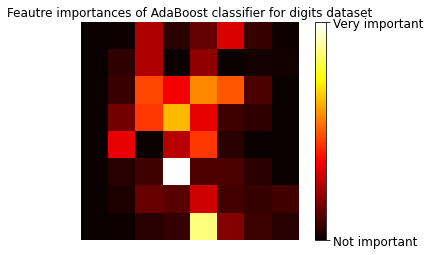

In [40]:
importances = ada_clf.feature_importances_
for i in range(len(importances)): #Remove NaN values
    if importances[i] != importances[i]:
        importances[i] = 0.0
plot_digit(importances)
#print(importances)
cbar = plt.colorbar(ticks=[importances.min(), importances.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.title("Feautre importances of AdaBoost classifier for digits dataset")
plt.show()

Now plotting all of our classifiers against one other for comparison

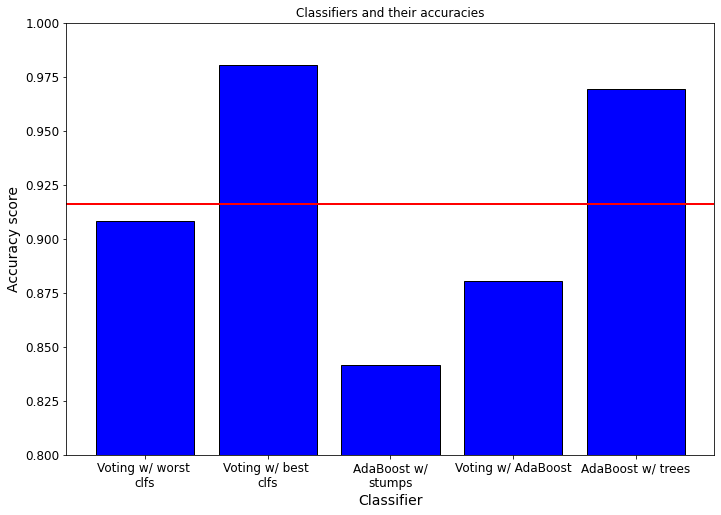

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure()
plot_data = [voting_worst_clf, voting_best_clf, ada_stump, voting_ada_clf, ada_clf_score]
mean = sum(plot_data) / len(plot_data)
ax = fig.add_axes([1, 1, 1.5 ,1.5]) #[left, bottom, width, height]
classifiers = ['Voting w/ worst \nclfs', 'Voting w/ best \nclfs', 'AdaBoost w/\nstumps', 'Voting w/ AdaBoost', 'AdaBoost w/ trees']
ax.axhline(mean, color='red', linewidth=2,label="mean")

ax.bar(classifiers, plot_data,  color='blue', edgecolor = "black")
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy score")
plt.xlabel("Classifier")
plt.title("Classifiers and their accuracies")
plt.show()

Clearly the ensemble of our best classiffiers is the highest performer. AdaBoost with stumps significantly underperforms against the average, however AdaBoost with decision trees significantly overperforms against the average. Since our ensemble of the best solo performers reached a very similar accuray to the highest solo model, it would be beneficial to use an ensemble model in practice due to the better generalisation across datasets. 